# Convolutional Neural Network for Fruit Detection

Developed by Pratham Shah

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import pandas as pd


In [2]:
train = "veggie_heap_training"
test = "veggie_heap_testing"

h = 128
w = 128
b = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

train_generator = datagen.flow_from_directory(
    train,
    target_size = (h, w),
    batch_size = b,
    class_mode ='categorical',
    subset = 'training'
)

# Regenerate val set without shuffling (keeps label order aligned with predictions)
val_generator = datagen.flow_from_directory(
    train,
    target_size=(h, w),
    batch_size=b,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Separate non-augmented test generator (no shuffle)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test,                     # "veggie_heap_testing"
    target_size=(h, w),
    batch_size=b,
    class_mode='categorical',
    shuffle=False
)

# Class index -> name mapping (same order everywhere)
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]


Found 8856 images belonging to 12 classes.
Found 979 images belonging to 12 classes.
Found 2424 images belonging to 12 classes.


In [3]:
model = models.Sequential([
    
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(h, w, 3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    
    layers.Dense(len(train_generator.class_indices), activation='softmax')
    
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0015,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/home/pratham/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-18 11:32:46.280582: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,699,724 (6.48 MB)

 Trainable params: 1,699,724 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
%load_ext tensorboard
%tensorboard --stop

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2025-09-18 11:32:46.866649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758175366.876266    8005 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758175366.879359    8005 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758175366.887097    8005 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758175366.887116    8005 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:17

In [5]:
from datetime import datetime

log_dir = f"logs/fit/{datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=False
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stop, tensorboard_cb],
    verbose=1
)


Epoch 1/15


/home/pratham/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


277/277 ━━━━━━━━━━━━━━━━━━━━ 65s 231ms/step - accuracy: 0.3731 - loss: 1.7971 - val_accuracy: 0.7845 - val_loss: 0.6682
Epoch 2/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 63s 228ms/step - accuracy: 0.7933 - loss: 0.6208 - val_accuracy: 0.8764 - val_loss: 0.3998
Epoch 3/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 63s 227ms/step - accuracy: 0.8599 - loss: 0.4241 - val_accuracy: 0.8846 - val_loss: 0.3683
Epoch 4/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 60s 218ms/step - accuracy: 0.8881 - loss: 0.3308 - val_accuracy: 0.9234 - val_loss: 0.3014
Epoch 5/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 68s 245ms/step - accuracy: 0.9027 - loss: 0.2966 - val_accuracy: 0.8876 - val_loss: 0.3793
Epoch 6/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 63s 227ms/step - accuracy: 0.8997 - loss: 0.2958 - val_accuracy: 0.9213 - val_loss: 0.3201
Epoch 7/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 60s 218ms/step - accuracy: 0.9155 - loss: 0.2382 - val_accuracy: 0.8927 - val_loss: 0.3646
Epoch 8/15
277/277 ━━━━━━━━━━━━━━━━━━━━ 58s 211ms/step - accuracy: 0.9153 - loss: 0.2395 - val

In [6]:
%tensorboard --logdir logs/fit --reload_interval 5

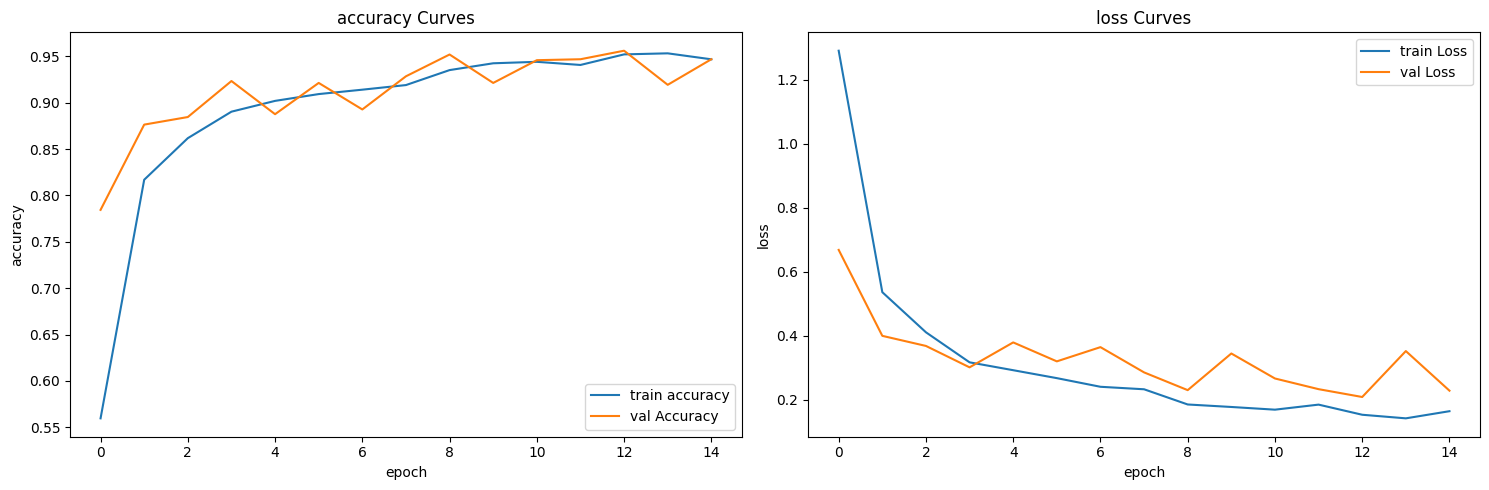

In [7]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train accuracy') #plots training and val accuracy v/s epoch
plt.plot(history.history['val_accuracy'], label='val Accuracy')
plt.title('accuracy Curves')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train Loss') #plots training and val loss v/s epoch
plt.plot(history.history['val_loss'], label='val Loss')
plt.title('loss Curves')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

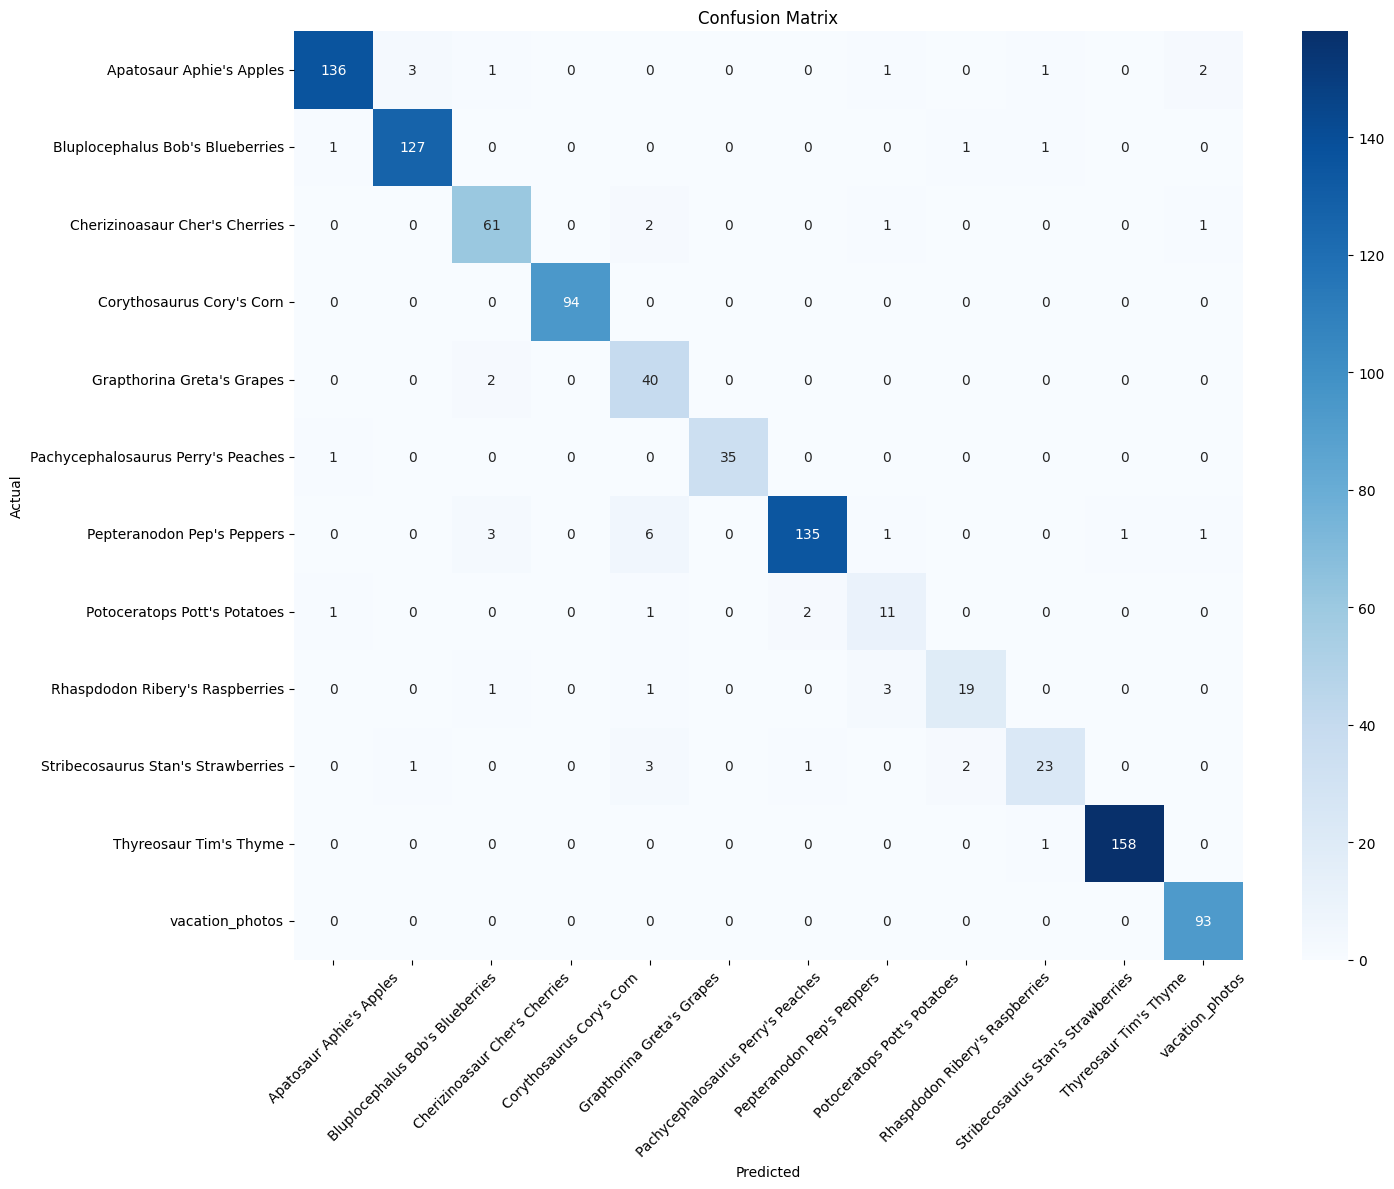

In [8]:
from sklearn.metrics import confusion_matrix

val_generator.reset()
y_true = val_generator.classes
y_prob = model.predict(val_generator, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 12))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


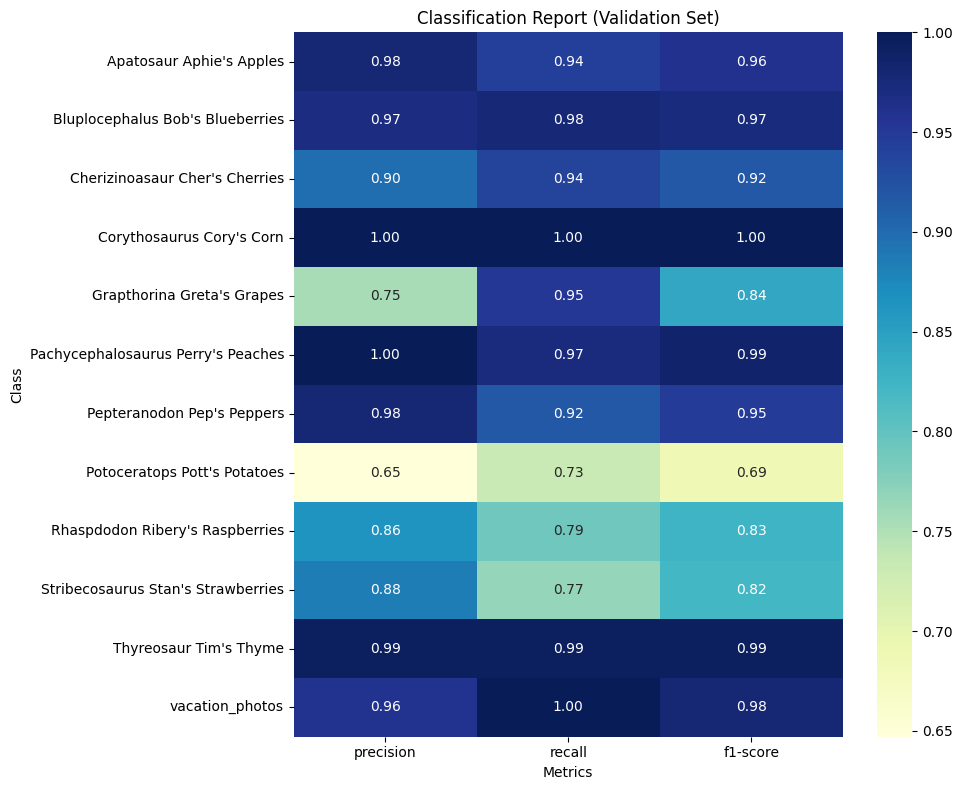

In [9]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0
)
df_report = pd.DataFrame(report).transpose()

df_heatmap = df_report[['precision', 'recall', 'f1-score']].iloc[:-3]
plt.figure(figsize=(10, 8))
sns.heatmap(df_heatmap, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Classification Report (Validation Set)')
plt.ylabel('Class')
plt.xlabel('Metrics')
plt.tight_layout()
plt.show()


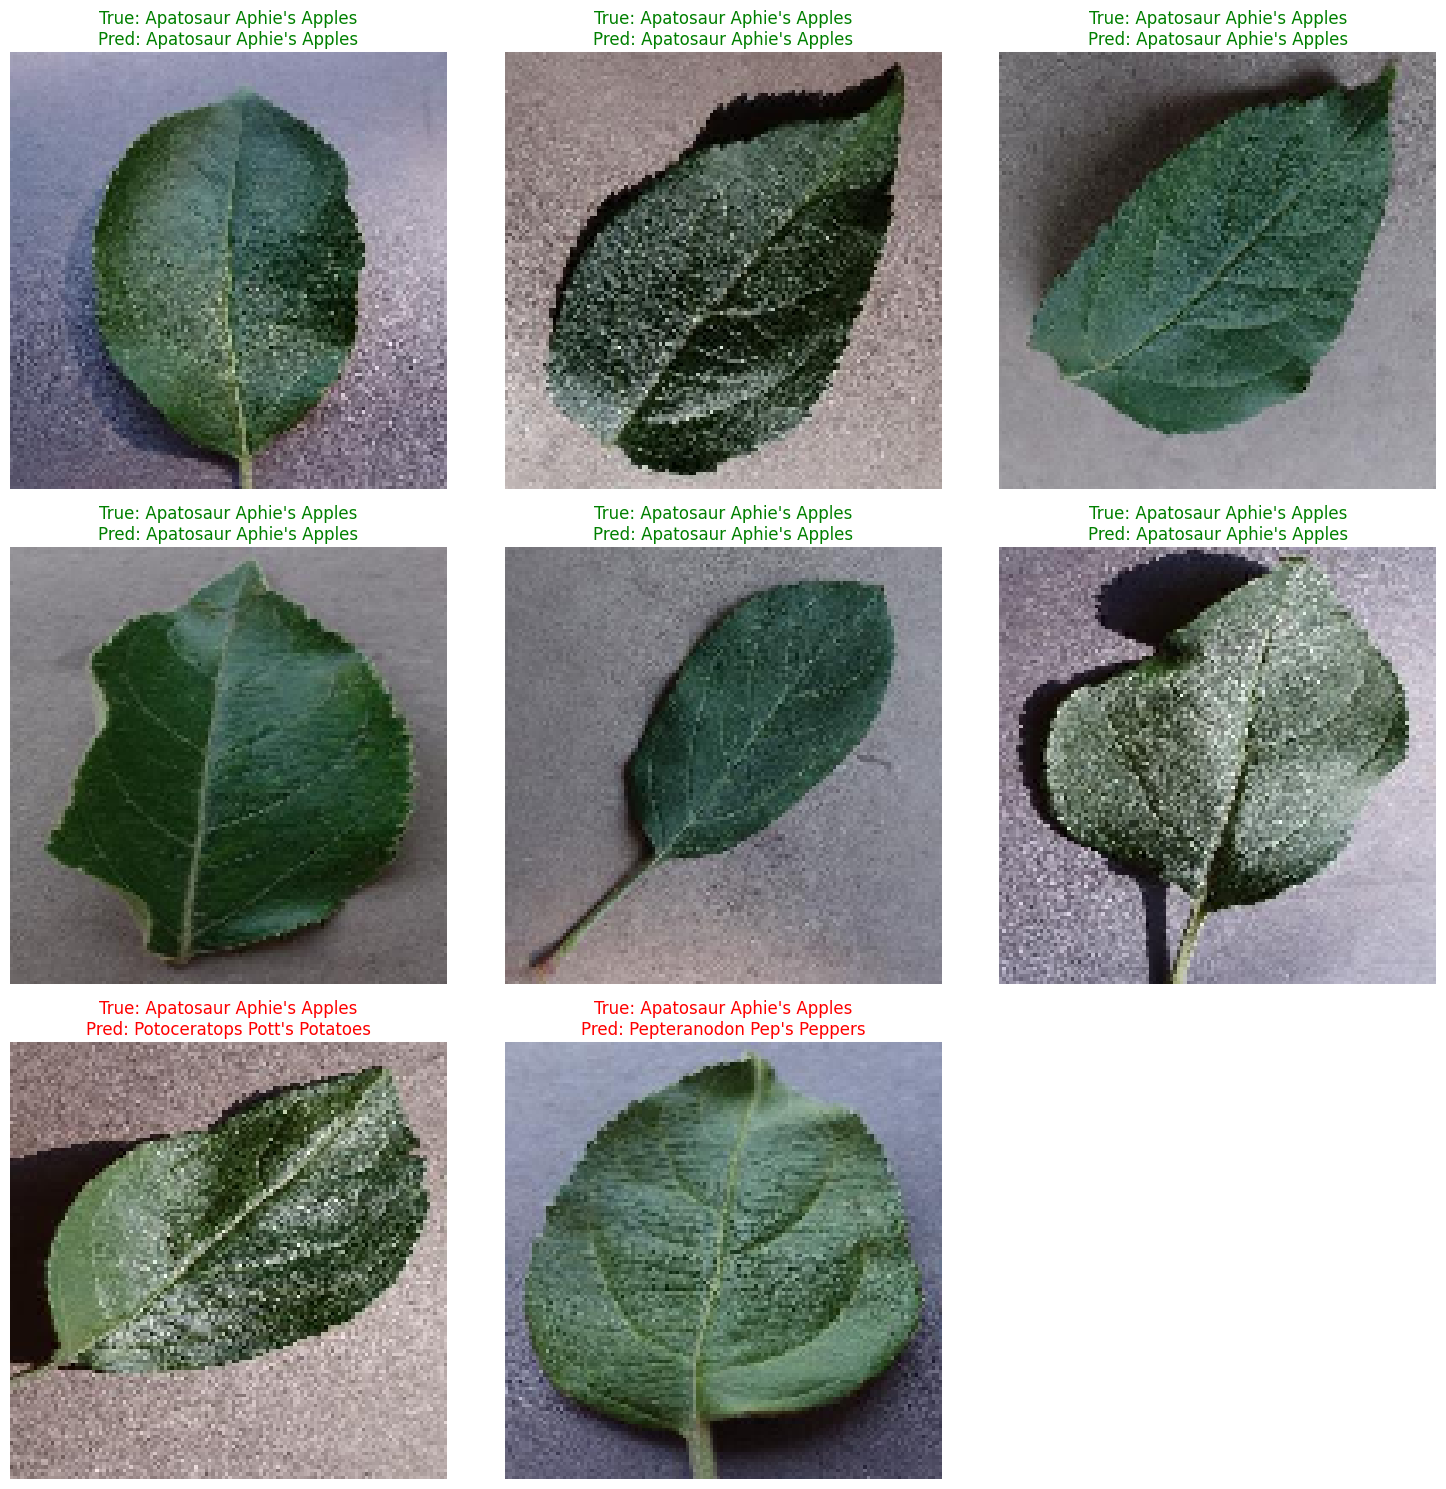

In [10]:
num_images = 8
test_generator.reset()
images, labels = next(test_generator)             # one batch
preds = model.predict(images, verbose=0)

plt.figure(figsize=(15, 15))
for i in range(num_images):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    true_idx = int(np.argmax(labels[i]))
    pred_idx = int(np.argmax(preds[i]))
    true_label = idx_to_class[true_idx]
    pred_label = idx_to_class[pred_idx]
    color = 'green' if true_idx == pred_idx else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()


# Conclusion

The CNN works extremely well, with 92%+ accuracy across training and testing.